In [1]:
import networkx as nx
from networkx.utils import py_random_state
from networkx.generators.random_graphs import _random_subset
from networkx.generators.classic import star_graph, complete_graph

import scipy.stats as stats
from scipy.optimize import curve_fit

import numpy as np

import matplotlib.pyplot as plt

Per via di problemi dovuti alle versioni delle librerie di networkx installate abbiamo aggiunto la funzione della libreria nel file per poterla usare senza preoccuparci delle versioni. La funzione originale può essere trovata nella documentazione della libreria al link https://networkx.org/documentation/stable/_modules/networkx/generators/random_graphs.html#barabasi_albert_graph

In [2]:
@py_random_state(2)
def barabasi_albert(n, m, seed=None, initial_graph=None):
    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási–Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )

    if initial_graph is None:
        G = star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási–Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    repeated_nodes = [n for n, d in G.degree() for _ in range(d)]
    source = len(G)
    while source < n:
        targets = _random_subset(repeated_nodes, m, seed)
        G.add_edges_from(zip([source] * m, targets))
        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * m)

        source += 1
    return G

# Distribuzione dei gradi

## Random Graph

In [3]:
N = int(1e4)
P = 0.05

G_r = nx.erdos_renyi_graph(N, P)
while min([d for n, d in G_r.degree()]) == 0:
    G_r = nx.erdos_renyi_graph(N, P)

k = np.arange(min([d for n,d in G_r.degree]), max([d for n,d in G_r.degree])+1)
p = [0]*len(k)

for i in range(len(k)):
    for n,d in G_r.degree:
        if k[i] == d:
            p[i] += 1

norm = sum(p)
p = [p[i]/norm for i in range(len(p))]

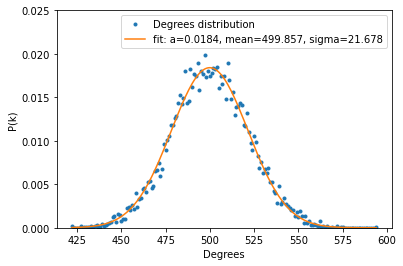

 - Data mean: 500.0272
 - Mean from gaussian fit: 499.856886664203 +/- 21.677914684263396


In [4]:
def gaus_law(x, a, mu=0, sigma=1):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

poptGaus, pcovGaus = curve_fit(gaus_law, k, p, 
                               p0 = [1, np.mean(k), 1])

fit_function = gaus_law(k, *poptGaus)

fig, ax = plt.subplots()

ax.plot(k, p, '.', label = 'Degrees distribution')
ax.plot(k, fit_function, '-',
        label = f"fit: a={round(poptGaus[0],4)}, mean={round(poptGaus[1],3)}, sigma={round(poptGaus[2],3)}")
plt.ylim([0., 0.025])

ax.set_xlabel("Degrees")
ax.set_ylabel("P(k)")      
ax.legend()

plt.show()

print(" - Data mean:", np.mean([d for n,d in G_r.degree]))
print(" - Mean from gaussian fit:", poptGaus[1], '+/-', poptGaus[2])

# print(stats.chisquare(p,fit_function))

## Scale-free

In [5]:
N = int(5e4)
M = 4

G_s = barabasi_albert(N, M)

k = np.arange(min([d for n,d in G_s.degree]), max([d for n,d in G_s.degree])+1)
p = [0]*len(k)

for i in range(len(k)):
    for n, d in G_s.degree:
        if k[i] == d:
            p[i] += 1

norm = sum(p)   
p = [p[i]/norm for i in range(len(p))]    

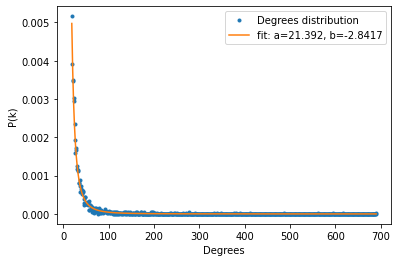

In [6]:
def power_law(x, a, b):
    return a*np.power(x, b)

x_low = 15
poptPower, pcovPower = curve_fit(power_law, k[x_low:], p[x_low:]) 

fit_function = power_law(k[x_low:], *poptPower)

fig, ax = plt.subplots()

ax.plot(k[x_low:], p[x_low:], '.', label = 'Degrees distribution')
ax.plot(k[x_low:], fit_function, '-',
        label = f"fit: a={round(poptPower[0],3)}, b={round(poptPower[1],4)}")

ax.set_xlabel("Degrees")
ax.set_ylabel("P(k)")
ax.xaxis
ax.legend()

#plt.xscale('log')
#plt.yscale('log')

plt.show()

# print(stats.chisquare(p[x_low:], fit_function))